# Moving Average Part 2: SL and TP Multiple Ratio

In [25]:
import oandapyV20
import oandapyV20.endpoints.trades as trades
import oandapyV20.endpoints.instruments as instruments
import json
import pandas as pd
import datetime as dt
import numpy as np

In [26]:
client = oandapyV20.API(access_token="0ca9619de6d428b6fdbcb4d20ef81268-cca1610e83cde7da5395d4468c2c1fe9")

performanceSummary = pd.DataFrame()
cols = ['Pair', 'Start Date', 'End Date', 'Total Trades', 'Avg Winning in Pips', 'Avg Losing in Pips', 'Total Pips Earned']

pair = 'EUR_USD'

cols = ['Date', 'Close']
dailyPrices = pd.DataFrame(columns=cols)
r = instruments.InstrumentsCandles(instrument=pair,
                               params={"count": 5000, "granularity": "D"})
raw_data = client.request(r)
candles = raw_data['candles']
for m in candles:
    new_row = {'Date': dt.datetime.strptime(m['time'][:10], '%Y-%m-%d'), 
               'Close': float(m['mid']['c'])}
    dailyPrices=dailyPrices.append(new_row, ignore_index=True)

shortTerm = 60
longTerm = 240

dailyPrices['EMA ' + str(shortTerm)] = dailyPrices['Close'].rolling(window=shortTerm).mean().round(5)
dailyPrices['EMA ' + str(longTerm)] = dailyPrices['Close'].rolling(window=longTerm).mean().round(5)

dailyPrices.set_index('Date',inplace=True)
dailyPrices.dropna(inplace=True)
dailyPrices['Close'] = dailyPrices['Close'].round(4)

longPos, shortPos, num, nTrades = 0,0,0,0
nPips = 0
wealth = 1
stopLoss = 0
takeProfit = 0
multiple = 2
cross = 0
returns = []
pips = []
ST = dailyPrices.columns[1]
LT = dailyPrices.columns[2]
bullStart = False
bearStart = False
entry_dates = []

dailyPrices['trading_book'] = wealth

for date in dailyPrices.index:
    if num == 0:
        if dailyPrices[ST][date] > dailyPrices[LT][date]:
            bullStart = True
        else:
            bearStart = True
    close = dailyPrices['Close'][date]  
    
    # No position opened - check for entry signal    
    if longPos == 0 and shortPos == 0:
        if dailyPrices[ST][date] > dailyPrices[LT][date]:        
            # No position - long entry signal
            if bullStart == False:
                nTrades += 1
                openLong = close
                #stopLoss = dailyPrices[LT][date]
                #takeProfit = openLong + (openLong - stopLoss) * multiple
                longPos = 1
                bearStart = False
                print("Opened long position at {} on {}".format(openLong,date))   
            
        if dailyPrices[ST][date] < dailyPrices[LT][date]:            
            # No position - short entry signal
            if bearStart == False:
                nTrades += 1
                openShort = close
                #stopLoss = dailyPrices[LT][date]
                #takeProfit = openShort - (stopLoss - openShort) * multiple
                shortPos = 1
                bullStart = False
                print("Opened short position at {} on {}".format(openShort,date))
    
    # if there is a long position open, check 
    if longPos > 0 and (openLong < dailyPrices[LT][date]):
        closeLong = close
        longPos = 0
        print("Closed long position at {} on {}".format(closeLong,date))
        print("===========================")
        ret = (closeLong/openLong - 1).round(3)
        returns.append(ret) 
        pipEarned = (closeLong - openLong) * 10000
        nPips = nPips + pipEarned
        pips.append(int(pipEarned))  
        
    if shortPos > 0 and (openShort > dailyPrices[LT][date]):
        closeShort = close
        shortPos = 0
        print("Closed short position at {} on {}".format(closeShort,date))
        print("===========================")
        ret = -(closeShort/openShort - 1).round(3)
        returns.append(ret)
        pipEarned = -(closeShort - openShort) * 10000
        nPips = nPips + pipEarned
        pips.append(int(pipEarned))
        wealth = wealth * (ret + 1)
    
    # SELL THE REMAINING POSITION AT THE END OF DATA            
    if (num == dailyPrices['Close'].count() - 1):
        # long position not closed
        if longPos != 0:
            closeLong = close
            longPos = 0
            print("Closed long position at {} on {}".format(closeLong,date))
            print("===========================")
            ret = (closeLong/openLong - 1).round(3)
            returns.append(ret)  
            pipEarned = (closeLong - openLong) * 10000
            nPips = nPips + pipEarned
            pips.append(int(pipEarned))
            wealth = wealth * (ret + 1)

        if shortPos != 0:
            closeShort = close
            shortPos = 0
            print("Closed short position at {} on {}".format(closeShort,date))
            print("===========================")
            ret = -(closeShort/openShort - 1).round(3)
            returns.append(ret)
            pipEarned = -(closeShort - openShort) * 10000
            nPips = nPips + pipEarned
            pips.append(int(pipEarned))
            wealth = wealth * (ret + 1)

    num += 1
    dailyPrices.loc[date,'trading_book'] = wealth

returns = returns[1:]
pips = pips[1:]

nLosing = 0
nWinning = 0
losingSum = 0
winningSum = 0

for pip in pips:
    if pip <= 0:
        nLosing += 1
        losingSum = losingSum + pip
    else:
        nWinning += 1
        winningSum = winningSum + pip

# if nWinning != 0:
#     avgWinning = winningSum/nWinning
# if nLosing != 0:
#     avgLosing = losingSum/nLosing


performanceSummary = performanceSummary.append({'Pair': pair,
                                               'Start Date': dailyPrices.index[0],
                                               'End Date': dailyPrices.index[-1],
                                               'Total Trades': int(len(pips)),
                                               'Total Pips Earned': sum(pips)}, ignore_index=True)

performanceSummary.set_index('Pair', inplace=True)

performanceSummary = performanceSummary[['Start Date', 
                                         'End Date', 
                                         'Total Trades', 
                                         'Total Pips Earned']]


    

Opened short position at 1.2557 on 2005-05-20 00:00:00
Closed short position at 1.2179 on 2005-10-05 00:00:00
Opened short position at 1.2128 on 2005-10-06 00:00:00
Closed short position at 1.2149 on 2006-01-07 00:00:00
Opened short position at 1.2087 on 2006-01-08 00:00:00
Closed short position at 1.2094 on 2006-01-26 00:00:00
Opened short position at 1.2106 on 2006-01-28 00:00:00
Closed short position at 1.2106 on 2006-01-28 00:00:00
Opened short position at 1.209 on 2006-01-29 00:00:00
Closed short position at 1.209 on 2006-01-29 00:00:00
Opened short position at 1.2156 on 2006-01-30 00:00:00
Closed short position at 1.2156 on 2006-01-30 00:00:00
Opened short position at 1.2065 on 2006-01-31 00:00:00
Closed short position at 1.19 on 2006-02-11 00:00:00
Opened short position at 1.1897 on 2006-02-12 00:00:00
Closed short position at 1.1053 on 2015-06-30 00:00:00
Opened short position at 1.1084 on 2015-07-01 00:00:00
Closed short position at 1.0993 on 2015-12-13 00:00:00
Opened short p

<AxesSubplot:title={'center':'EUR_USD MA CrossOver L/S Strategy Backtesting'}, xlabel='Date'>

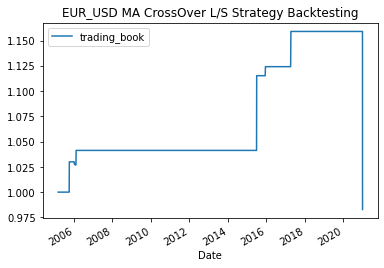

In [27]:
dailyPrices.plot(y='trading_book', title=pair + ' MA CrossOver L/S Strategy Backtesting')

In [28]:
performanceSummary

,Start Date,End Date,Total Trades,Total Pips Earned
Pair,,,,
EUR_USD,2005-03-09,2020-12-30,10.0,-205.0
